In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist

# Convolutional Neural Network

This notebook contains a detailed discussion and implementation of convolutional neural networks. Only numpy is used for matrix calculation. Rest of the code is developed from scratch. Each implementation contains an accompanying theoretical discussion along with it. It assumes that the reader has a basic understanding of vector calculation and how neural networks work.

## Dataset

MNIST handwritten digit dataset has been used for classification. The dataset contains 70,000 images of different digits (0-9). Each image is a 28x28 pixel grayscale image. The value of each pixel can be between 0 and 255 (inclusive). 

For the neural network, we convert the two dimensional image to three dimensional vector consisting of 28x28x1 pixel values. Each pixel value is considered as a feature. We scale the value so that the value of each pixel ranges between 0 and 1 (inclusive).

__Dataset Architecture:__

Input shape [?, 28, 28, 1] : The input to the neural network contains a four dimensional matrix. The first dimension (?) contains the batch size (number of images provided to the network), the second dimension (28) contains the width of each sample, the thir dimenstion (28) contains the height of each sample, and the fourth dimension (1) contains the number of channels each sample.

Output Label [?, 10]: The output of the network contains two dimensional matrix. The first dimension (?) contains the batch size (number of images provided to the network) and the second dimension (10) contains the number of output classes available for the network.

Train dataset shape: (60000, 28, 28, 1), train label shape: (60000,)
Test dataset shape: (10000, 28, 28, 1), test label shape: (10000,)
Pixel value range: 0.0 - 1.0


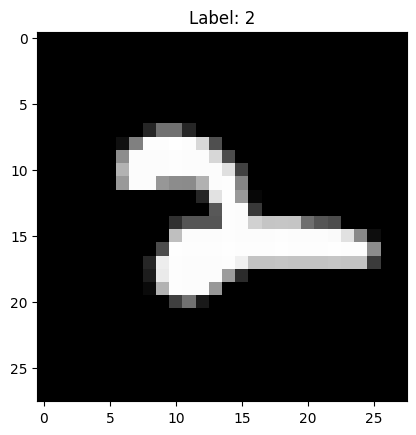

In [46]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train, X_test = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)/255.0, X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)/255.0 # Scaling the dataset

# X_train, X_test = X_train.transpose(3, 1, 2, 0), X_test.transpose(3, 1, 2, 0)
print(f"Train dataset shape: {X_train.shape}, train label shape: {y_train.shape}")
print(f"Test dataset shape: {X_test.shape}, test label shape: {y_test.shape}")

print(f"Pixel value range: {np.min([np.min(X_train), np.min(X_test)])} - {np.max([np.max(X_train), np.max(X_test)])}")

plt.figure()
i = np.random.randint(0, len(X_train))
plt.title("Label: " + str(y_train[i]))
plt.imshow(X_train[i, :, :, 0], cmap='gray')
plt.show()

## One hot encoding

In the dataset, the output label of each image is a value between 0-9. However, when performing classification the output of the network needs to be a probability distribution of each output class. This means that if we have an image of the digit '2' and the output class is the number '2', we need to convert that output to a vector as follows: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

This process of converting a number to a vector is known as one-hot encoding. The network itself will provide the output as a one-hot encoded vector of probability distribution. We need to convert the train and test labels to the same form in order to compute the error between the predicted and true output.

In [4]:
def one_hot_encoded(y, total_classes):
    """
    Calculates the one-hot encoded vector from the output label
    @param y [1D numpy array]: A vector containing output labels
    @param total_classes [int]: Number of total classes available in the output layer
    
    Returns [2D numpy array]: one-hot encoded vector for the output labels
    """
    if len(y.shape) >= 2:
        return y
    encoded = np.zeros((y.shape[0], total_classes))
    encoded[np.arange(y.shape[0]), y] = 1
    return encoded

In [5]:
sample_classes = np.array([0, 1, 2, 3])
one_hot_encoded_classes = one_hot_encoded(sample_classes, 10)
for i in range(len(sample_classes)):
    print(f"Label {sample_classes[i]} : One hot encoded vector => {one_hot_encoded_classes[i]}")

Label 0 : One hot encoded vector => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 1 : One hot encoded vector => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label 2 : One hot encoded vector => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Label 3 : One hot encoded vector => [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Activation Functions

Activation functions are used to introduce non-linearity to the output of a specific layer. The following activation functions are used for the network:

1. __Rectified Linear Unit (ReLU):__ This activation function is applied to the output of hidden layers. It reduces the likelihood of vanishing gradient. Furthermore, it introduces sparsity and it is easier to calculate the derivative of this function.


2. __Softmax:__ This activation function is applied to the final output produced by the output layer. It is used to calculate the probablity distributio of each output class/label. This helps in classification.

### ReLU

\begin{equation}
Y = f(x) = \begin{cases}
0 \text{ if } x < 0\\
x \text{ otherwise}
\end{cases}
\end{equation}

ReLU replaces all negative numbers to zero. The derivative of ReLU is calculated as follows:

\begin{equation}
Y' = f'(x) = \begin{cases}
0 \text{ if } x = 0\\
1 \text{ otherwise}
\end{cases}
\end{equation}

The slope of positive numbers are 1 as positive input to the function is same as the output of the function.



In [6]:
def relu(x):
    """
    Computes the ReLU activated output
    @aram x [numpy array or int]: The non-activated output
    Returns [numpy array or int]: The activated output
    """
    return np.maximum(0.0, x)

def derivative_relu(x):
    """
    Computes the derivative of the ReLU activated output
    @aram x [numpy array or int]: The activated output
    Returns [numpy array or int]: The derivative of the activated output
    """
    return np.where(x > 0, 1.0, 0.0)

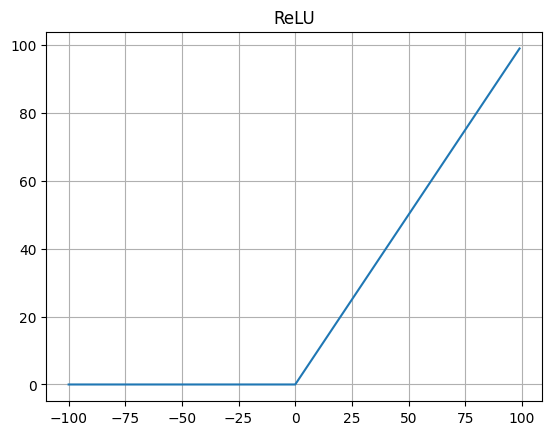

In [7]:
plt.figure()
plt.title('ReLU')
plt.plot(np.arange(-100, 100, 1), [relu(i) for i in np.arange(-100, 100, 1)])
plt.grid()
plt.show()

### Softmax

\begin{equation}
Y = f(x) = \frac{e^{x - max(x)}}{\sum_{i=0}^n e^{x - max(x)}}
\end{equation}

Here, 'n' is the total number of output classes (as this function is applied to the output layer only) which is 10.

Softmax takes each output (probability of class label) and exponentially increases it and finally scales it down to range between 0 and 1. It provides an advantage that the class output which has a higher probability is increased a lot (due to exponential increase) and after scaling becomes close to one. On the other hand, all other class labels become close to zero.

In [9]:
def softmax(x):
    """
    Computes the softmax activated output
    @aram x [2D numpy array]: The non-activated output provided by output layer
    Returns [2D numpy array]: The activated output provided by output layer
    """
    exp_x =  np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x/np.sum(exp_x, axis=1, keepdims=True)

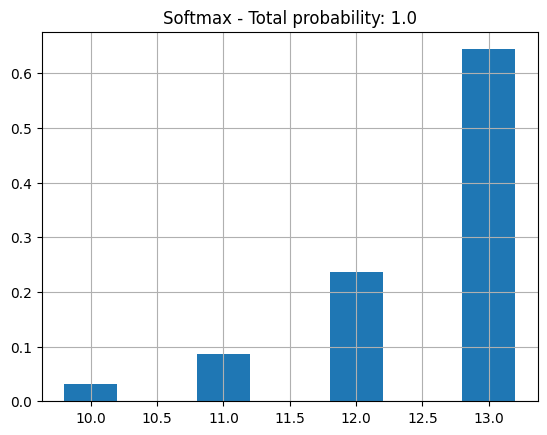

In [10]:
x = np.array([[10, 11, 12, 13]])
y = softmax(x)
plt.figure()
plt.title(f'Softmax - Total probability: {np.sum(y[0])}')
plt.bar(x[0], y[0], width=0.4)
plt.grid()
plt.show()

## Optimizers

When performing backpropagation algorithm, we normally use gradient descent to calculate the gradient of weights and biases of each layer. Optimization algorihms are a variant of gradient descent that is used to improve the performance of the backpropagation. We will use the following optimization algorithm:

1. Adagrad

2. RMSProp

3. Adam

Source: [https://www.geeksforgeeks.org/intuition-of-adam-optimizer/](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/)

In [11]:
def adagrad(momentum, gradient_of_weight, beta=0.9):
    """
    Computes the adagrad optimization.
    @param momentum [2D numpy array]: Current momentum
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta [float]: Decay rate of average gradient
    Returns updated momentum and gradient_of_weight
    """
    momentum = (beta * momentum) + ((1 - beta) * gradient_of_weight)
    gradient_of_weight = momentum.copy()
    return momentum, gradient_of_weight

def rmsprop(sum_of_square, gradient_of_weight, beta=0.9999, epsilon=1e-8):
    """
    Computes the rmsprop optimization.
    @param sum_of_square [2D numpy array]: Current sum of squares of gradient
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta [float]: Decay rate of average gradient
    @param epsilon [float]: Small positive constant to avoid division by zero
    Returns updated sum_of_square and gradient_of_weight
    """
    sum_of_square = (beta * sum_of_square) + ((1 - beta) * np.square(gradient_of_weight))
    gradient_of_weight *= (1.0 /(np.sqrt(sum_of_square) + epsilon))
    return sum_of_square, gradient_of_weight

def adam(momentum, sum_of_square, gradient_of_weight, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    """
    Computes the adam optimization.
    @param momentum [2D numpy array]: Current momentum
    @param sum_of_square [2D numpy array]: Current sum of squares of gradient
    @param gradient_of_weight [2D numpy array]: Computed gradients of the weight of a layer
    @param beta_1 [float]: Decay rate of average gradient for adagrad calculation
    @param beta_2 [float]: Decay rate of average gradient for rmsprop calculation
    @param epsilon [float]: Small positive constant to avoid division by zero
    Returns updated momentum, sum_of_square, and gradient_of_weight
    """
    momentum = (beta_1 * momentum) + ((1 - beta_1) * gradient_of_weight)
    sum_of_square = (beta_2 * sum_of_square) + ((1 - beta_2) * np.square(gradient_of_weight))
    gradient_of_weight = momentum/(np.sqrt(sum_of_square) + epsilon)
    return momentum, sum_of_square, gradient_of_weight

## Loss and Accuracy

When training the network, we need to periodically test the accuracy and loss of the network. Categorical Crossentropy is an algorithm that is used to calculate the loss of the network by comparing the true output label with the output predictions provided by the network.

In [12]:
def categorical_crossentropy(y_true, y_pred):
    """
    Computes categorical crossentropy between the predicted and true labels.
    @param y_true [2D Numpy array]: True labels, shape (num_examples, num_classes)
    @pram y_pred [2D Numpy array]: Predicted labels, shape (num_examples, num_classes)

    Returns [float]: the categorical crossentropy loss between y_true and y_pred
    """
    # Avoid numerical instability by clipping values to a minimum epsilon
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)

    # Compute cross-entropy loss
    ce_loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    return ce_loss

def accuracy(y_true, y_pred):
    """
    Computes accuracy of the network based on the predicted output and the expected/true output.
    @param y_true [2D Numpy array]: True labels, shape (num_examples, num_classes)
    @pram y_pred [2D Numpy array]: Predicted labels, shape (num_examples, num_classes)

    Returns [float]: the accuracy of the network
    """
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

# Part 1 - Dense Layers

## Forward propagation

\begin{equation}
Output, Y = Activation(W.x + b)
\end{equation}

Here,

- 'W' is the weight matrix of the current layer

- 'x' is the input matrix provided to the current layer

- 'b' is the bias for the current layer

If the previous layer 'A' contains 2 neurons and the current layer 'B' contains 3 neurons, then the weight matrix

\begin{equation}
W = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack
\end{equation}

The input (assuming it contains 1 sample input

\begin{equation}
x = \left\lbrack \matrix{x_{A_1} x_{A_2}} \right\rbrack
\end{equation}

and the bias of the current layer

\begin{equation}
b = \left\lbrack \matrix{b_{B_1} b_{B_2} b_{B_3}} \right\rbrack
\end{equation}

Therefore the non-activated output

\begin{equation}
z = \left\lbrack \matrix{z_{B_1} z_{B_2} z_{B_3}} \right\rbrack
\end{equation}

In [13]:
def feed_forward(x, W, b, activation):
    """
    Returns the activated output for a layer.
    @param x [2D numpy array] : The input to the current layer. First dimension is the number of samples 
    and the second dimension is the number of features of each sample.
    
    @param W [2D numpy array] : The weight of the current layer. First dimension is the number of 
    neurons in previous layer/input and the second dimension is the number of neurons in current layer.
    
    @param b [2D numpy array] : Bias of the current layer. The 
    first dimension is always 1 and the second dimension is the number of neurons in current layer
    
    @param activation [function]: The activation function for the current layer.
    """
    return activation(np.dot(x, W) + b)

## Error of output layer

The error of output layer is calculated by subtracting the value (probability) of each class of each sample from the value of each class of the training label (one hot encoded).

\begin{equation}
Error, E = Y^{predicted} - Y^{true}
\end{equation}

If the final output contains 1 sample and 3 classes, where

\begin{equation}
Y^{predicted} = \left\lbrack \matrix{Y^P_1 Y^P_2 Y^P_3} \right\rbrack
\end{equation}

and

\begin{equation}
Y^{true} = \left\lbrack \matrix{Y^T_1 Y^T_2 Y^T_3} \right\rbrack
\end{equation}

then

\begin{equation}
\left\lbrack \matrix{E_1 E_2 E_3} \right\rbrack = \left\lbrack \matrix{Y^P_1 Y^P_2 Y^P_3} \right\rbrack - \left\lbrack \matrix{Y^T_1 Y^T_2 Y^T_3} \right\rbrack
\end{equation}

In [14]:
def calculate_output_error(y_true, y_pred):
    """
    Computes error of the output layer.
    @param y_true [2D Numpy array]: True labels, shape (num_examples, num_classes)
    @pram y_pred [2D Numpy array]: Predicted labels, shape (num_examples, num_classes)

    Returns [2D Numpy array]: the error vector
    """
    return y_pred - y_true

## Error of hidden layers

The error of each hidden layer's output is calculated by computing the dot product between the error of the next layer and weight matrix of the next layer. The result is then multiplied (element-wise) by the non-activated input to the next layer. 

The dot product provides a weighted error of the next layer. The input to the next layer is actually output of the current layer. So, multiplying the weighted error by the current layer's output provides the amount contribution that made to the final error by current layer's output.

Let the current layer be 'A' and the next layer be 'B'. 

Let, the error produced by the next layer be '$E_B$' where

\begin{equation}
E_B =  \left\lbrack \matrix{E_{B_1} E_{B_2} E_{B_3}} \right\rbrack
\end{equation}

and the weight matrix of the current layer be 

\begin{equation}
W_B = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack
\end{equation}

and non-activated output of the current layer be

\begin{equation}
Y'_A =  \left\lbrack \matrix{Y'_{A_1} Y'_{A_2}} \right\rbrack
\end{equation}

Therefore, error of the current layer

\begin{equation}
E_A =  (E_B . W^T_B) * Y'_A \\
E_A = (\left\lbrack \matrix{E_{B_1} E_{B_2} E_{B_3}} \right\rbrack . \left\lbrack \matrix{W_{A_1B_1} W_{A_2B_1} \cr W_{A_1B_2} W_{A_2B_2} \cr W_{A_1B_3} W_{A_2B_3}} \right\rbrack) * \left\lbrack \matrix{Y'_{A_1} Y'_{A_2}} \right\rbrack \\
E_A = \left\lbrack \matrix{E_{A_1} E_{A_2}} \right\rbrack
\end{equation}

In [15]:
def calculate_hidden_error(error_next_layer, weight_next_layer, non_activated_output_current_layer):
    """
    Calculates output of the hidden layer
    @param error_next_layer [2D Numpy array]: Error generated by the next layer. First dimension is the number of samples
    @param weight_next_layer [2D Numpy array]: Weight matrix of the next layer
    @param non_activated_output_current_layer [2D Numpy array]: Non-activated output of the current layer
    
    Returns [2D Numpy array]: Error of the current layer
    """
    return  np.dot(error_next_layer, weight_next_layer.T) * non_activated_output_current_layer

## Gradient of weights of current layer

Gradient is the amount which needs to be subtracted from existing weight/biases in order to account for the error in one iteration. This update changes the weight to minimize the error for the outputs produced.

To calculate the gradient of weights of the current layer, we compute the dot product between the input (transposed) provided to the current layer and error of the current layer. We, then scale the result by dividing it with the total number of sample data provided in the input.

Let 'G' be gradient of the current layer 'B', 'Y_A' be input to the current layer and output of the previous layer 'A', and 'E_B' be the error of the current layer's output. Let the total number of sample data in input be 'n'. Let the learning rate be '$\alpha$'. Therefore,

\begin{equation}
Y_A = \left\lbrack \matrix{Y_{A_1} Y_{A_2}} \right\rbrack
\end{equation}

and 

\begin{equation}
E_B = \left\lbrack \matrix{E_{B_1} E_{B_2} E_{B_3}} \right\rbrack
\end{equation}

Therefore,

\begin{equation}
G_B = (Y^T_A . E_B) * \frac{1}{n} \\
G_B = (\left\lbrack \matrix{Y_{A_1} \cr Y_{A_2}} \right\rbrack . \left\lbrack \matrix{E_{B_1} E_{B_2} E_{B_3}} \right\rbrack)  * \frac{1}{n} \\
G_B = \left\lbrack \matrix{G^B_{A_1B_1} G^B_{A_1B_2} G^B_{A_1B_3} \cr G^B_{A_2B_1} G^B_{A_2B_2} G^B_{A_2B_3}} \right\rbrack
\end{equation}

Since, weight of the layer 'B' is 

\begin{equation}
W_B = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack
\end{equation}

we update the weight by subtracting the gradient from current weight

\begin{equation}
W^{updated}_B = W_B - \alpha * G_B \\
W^{updated}_B = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack - \alpha * \left\lbrack \matrix{G^B_{A_1B_1} G^B_{A_1B_2} G^B_{A_1B_3} \cr G^B_{A_2B_1} G^B_{A_2B_2} G^B_{A_2B_3}} \right\rbrack
\end{equation}

__Note: When using an optimizer, we first compute the gradient and then optimize the gradient using optimization algorithm. We then subtract the optimized gradient from the current weights in order to get the updated weights__

In [16]:
def calculate_weight_gradient(error_current_layer, input_current_layer):
    """
    Computes gradeint of the weights of the current layer.
    @param error_current_layer [2D Numpy array]: Error generated by the current layer's output. First dimension is the number 
    of samples
    @param input_current_layer [2D Numpy array]: Input vector provided to the current layer. First dimension is the number 
    of samples
    
    Returns [2D Numpy array]: Gradient of the weights of the current layer
    """
    return (1.0/input_current_layer.shape[0]) * np.dot(input_current_layer.T, error_current_layer)

## Gradient of bias of current layer

Gradient is the amount which needs to be subtracted from existing weight/biases in order to account for the error in one iteration. This update changes the bias to minimize the error for the outputs produced.

To calculate the gradient of bias of the current layer, we calculate the sum of error of all data samples of each neuron in the current layer and divide it by the total number of data samples provided to the current layer.

Let 'G' be gradient of the bias of current layer 'B' and 'E_B' be the error of the current layer's output. Let the total number of sample data in input be 'n' and the total number of neurons be 3. Let the learning rate be '$\alpha$'. Therefore,


\begin{equation}
E_B = \left\lbrack \matrix{E_{B_1} E_{B_2} E_{B_3}} \right\rbrack
\end{equation}

Therefore,

\begin{equation}
G_B = \frac{1}{n} * \left\lbrack \matrix{ (\sum^n_{i=0} E_{B_1}) (\sum^n_{i=0} E_{B_2}) (\sum^n_{i=0} E_{B_3}) } \right\rbrack \\
G_B = \left\lbrack \matrix{G_{B_1} G_{B_2} G_{B_3}} \right\rbrack
\end{equation}

We update the bias by subtracting the gradient from current bias

\begin{equation}
B^{updated}_B = B_B - \alpha * G_B \\
B^{updated}_B = \left\lbrack \matrix{B_{B_1} B_{B_2} B_{B_3}} \right\rbrack - \alpha * \left\lbrack \matrix{G_{B_1} G_{B_2} G_{B_3}} \right\rbrack
\end{equation}

In [17]:
def calculate_bias_gradient(error_current_layer):
    """
    Computes gradeint of the weights of the current layer.
    @param error_current_layer [2D Numpy array]: Error generated by the current layer's output. First dimension is the number 
    of samples
    
    Returns [2D Numpy array]: Gradient of the bias of the current layer
    """
    return (1.0/error_current_layer.shape[0]) * np.sum(error_current_layer, axis=0, keepdims=True)

## Update weights and biases

__1. Weights:__

\begin{equation}
W^{updated}_B = W_B - \alpha * G_B \\
W^{updated}_B = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack - \alpha * \left\lbrack \matrix{G^B_{A_1B_1} G^B_{A_1B_2} G^B_{A_1B_3} \cr G^B_{A_2B_1} G^B_{A_2B_2} G^B_{A_2B_3}} \right\rbrack
\end{equation}

__2. Biases:__

\begin{equation}
B^{updated}_B = B_B - \alpha * G_B \\
B^{updated}_B = \left\lbrack \matrix{B_{B_1} B_{B_2} B_{B_3}} \right\rbrack - \alpha * \left\lbrack \matrix{G_{B_1} G_{B_2} G_{B_3}} \right\rbrack
\end{equation}

__Note: When using an optimizer, we first compute the gradient and then optimize the gradient using optimization algorithm. We then subtract the optimized gradient from the current weights in order to get the updated weights__

In [18]:
def update_weights(weights, gradient, learning_rate):
    """
    @param weights [2D Numpy array]: Weight matrix of the current layer
    @param gradient [2D Numpy array]: Gradient of the weight of the current layer
    @param learning_rate [float]: Learning rate
    
    Returns [2D Numpy array]: Updated weights
    """
    return weights - (learning_rate * gradient)

def update_biases(biases, gradient, learning_rate):
    """
    @param biases [2D Numpy array]: Bias matrix of the current layer
    @param gradient [2D Numpy array]: Gradient of the weight of the current layer
    @param learning_rate [float]: Learning rate
    
    Returns [2D Numpy array]: Updated biases
    """
    return biases - (learning_rate * gradient)

# Part 2 - Convolutional Layers

## Calculating shape of output

\begin{equation}
O = (I + 2 * P - K) // S + 1
\end{equation}

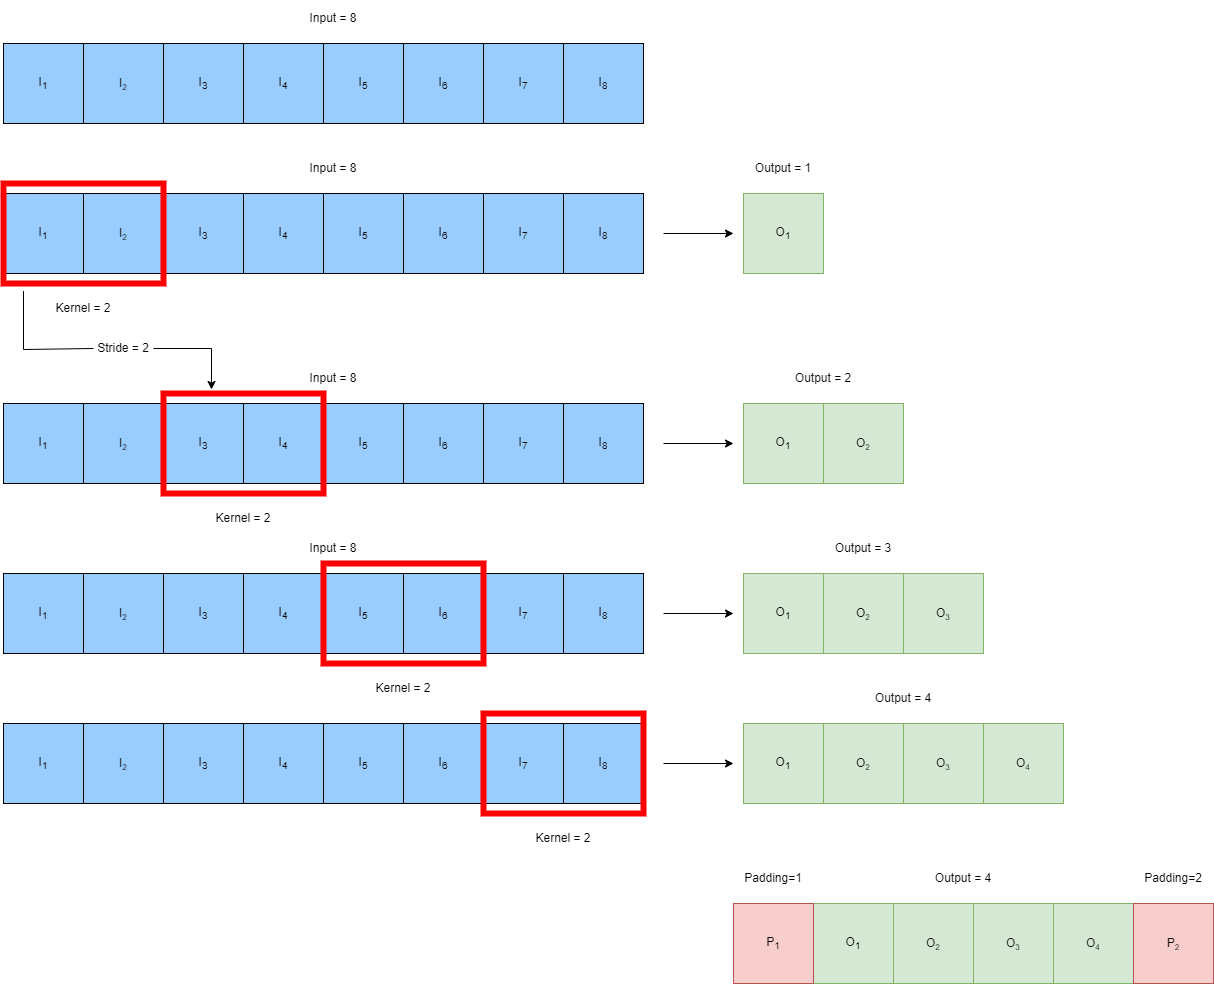

In [19]:
def conv_calculate_output_shape(input_size, kernel_size, padding_size, stride):
    """
    @param input_size [Integer]: Size of the input
    @param kernel_size [Integer]: Size of the kernel
    @param padding_size [Integer]: Size of the padding
    @param stride [Integer]: Size of the stride
    
    Returns [Integer]: Output size
    """
    return (input_size + 2 * padding_size - kernel_size) // stride + 1

In [25]:
input_size = 8
kernel_size = 2
padding_size = 2
stride = 2
print(conv_calculate_output_shape(input_size, kernel_size, padding_size, stride))

6


## Add padding


In [50]:
def conv_add_padding(inputs, padding_shape):
    """
    inputs [4D Numpy array]: First dimenstion contains batch size, second dimension contains height, third dimension contains width, 
    and  last dimension contains number of channels
    
    padding_size [Tuple]: Each index contains the padding size of each dimension (height, width, depth)
    
    Retunrs [4D Numpy array]: Zero padded inputs
    """
    if padding_size > 0 and len(inputs.shape) > 2:
        total_padding_shape = [(0, 0)] # No padding for batch size
        for i in range(len(inputs.shape) - 2):
            number_of_zeros_at_start = padding_shape[i]
            number_of_zeros_at_end = padding_shape[i]
            total_padding_shape += [(number_of_zeros_at_start, number_of_zeros_at_end)]
            
        total_padding_shape += [(0, 0)] # No padding for channels
        
        return np.pad(inputs, total_padding_shape, mode='constant')
        
    return inputs

In [51]:
a = np.array([
        [
            [
                [0.01, 0.02, 0.03, 0.04]
            ],
            [
                [0.05, 0.06, 0.07, 0.08]
            ],
            [
                [0.09, 0.10, 0.11, 0.12]
            ]
        ],
        [
            [
                [0.13, 0.14, 0.15, 0.16]
            ],
            [
                [0.17, 0.18, 0.19, 0.20]
            ],
            [
                [0.21, 0.22, 0.23, 0.24]
            ]
        ]
    ])

print(a)
a_padded = conv_add_padding(a, (2, 1,))
print(a.shape)
print(a_padded.shape)
print(a_padded)

[[[[0.01 0.02 0.03 0.04]]

  [[0.05 0.06 0.07 0.08]]

  [[0.09 0.1  0.11 0.12]]]


 [[[0.13 0.14 0.15 0.16]]

  [[0.17 0.18 0.19 0.2 ]]

  [[0.21 0.22 0.23 0.24]]]]
(2, 3, 1, 4)
(2, 7, 3, 4)
[[[[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.01 0.02 0.03 0.04]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.05 0.06 0.07 0.08]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.09 0.1  0.11 0.12]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]]


 [[[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.13 0.14 0.15 0.16]
   [0.   0.   0.   0.  ]]

  [[0.   0.   0.   0.  ]
   [0.17 0.1

## Forward Propagation - 2D Convolution (Width, Height, Channels)

In [81]:
def conv2d_convolve(inputs, filters, biases, height_size, width_size, filter_number, stride_height, stride_width):
    """
    Inputs [3D Numpy array]: First dimension contains height, second dimension contains width, 
    and  last dimension contains number of channels
    
    filters [4D Numpy array]: First dimension contains height, second dimension contains width, third dimension contains number 
    of channels, and last dimension contains number of filters
    
    biases [4D Numpy array]: First dimension contains height (1), second dimension width (1), third dimension number of channels (1) 
    and last dimension contains number of filters i.e. 1 bias for each filter
    
    height_size [Integer]: Size of the height of output
    width_size [Integer]: Size of the width of output
    filter_number [Integer]: Index number of the filter to use
    stride_height  [Integer]: Stride size along height of input
    stride_width  [Integer]: Stride size along width of input
    
    Returns [3D Numpy array]: The convolved output
    """
    filter_height, filter_width, filter_channels, num_filters = filters.shape
    
    # Calculate the range of the height for each convolution must be performed
    h_start = height_size * stride_height
    h_end = h_start + filter_height
    
    # Calculate the range of the width for each convolution must be performed
    w_start = width_size * stride_width
    w_end = w_start + filter_width
    
    # Get the slice of image within the range to perform convolution
    x_slice = inputs[h_start:h_end, w_start:w_end, :]
    
    # Get the kernel from the filters to perform convolution
    kernel = filters[:, :, :, filter_number]
    
    return np.sum(x_slice * kernel) + biases[:, :, :, filter_number]


def conv2d_feed_forward(inputs, filters, biases, padding_shape, stride_shape, activation):
    """
    inputs [4D Numpy array]: First dimenstion contains batch size, second dimension contains height, third dimension contains width, 
    and  last dimension contains number of channels
    
    filters [4D Numpy array]: First dimension contains height, second dimension contains width, third dimension contains number 
    of channels, and last dimension contains number of filters
    
    biases [4D Numpy array]: First dimension contains height (1), second dimension width (1), third dimension number of channels (1) 
    and last dimension contains number of filters i.e. 1 bias for each filter
    
    padding_shape [tuple]: First value contains the padding size of height and the second value contains that of width
    
    stride_shape [tuple]: First value contains the stride size of height and the second value contains that of width
    
    activation [function]: The activation function used
    
    Returns [4D Numpy array]: First dimenstion contains batch size, second dimension contains height, third dimension contains width, 
    and  last dimension contains number of filters used to calculate the output
    """
    _, input_height, input_width, _ = inputs.shape
    inputs = conv_add_padding(inputs, padding_shape) # Add padding if required
    
    batch_size, padded_input_height, padded_input_width, input_channels = inputs.shape # Input shape including padding
    filter_height, filter_width, filter_channels, num_filters = filters.shape
    padding_height, padding_width = padding_shape
    stride_height, stride_width = stride_shape
    
    
    # Calculate output width
    output_height = conv_calculate_output_shape(input_height, filter_height, padding_height, stride_height)
    # Calculate output height
    output_width = conv_calculate_output_shape(input_width, filter_width, padding_width, stride_width)
    
    # Initialize the output tensor
    outputs = np.zeros((batch_size, output_height, output_width, num_filters), dtype=np.float32)
    
    # Perform the convolution operation
    for batch_idx in range(batch_size): # For each sample
        for height_idx in range(output_height): # For each height
            for width_idx in range(output_width): # For each width
                for filter_idx in range(num_filters): # For each filter
                    # Perform convolution
                    outputs[batch_idx, height_idx, width_idx, filter_idx] = conv2d_convolve(
                        inputs[batch_idx], filters, biases, 
                        height_idx, width_idx, filter_idx, stride_height, stride_width
                    )
    return activation(outputs)
    
    
    

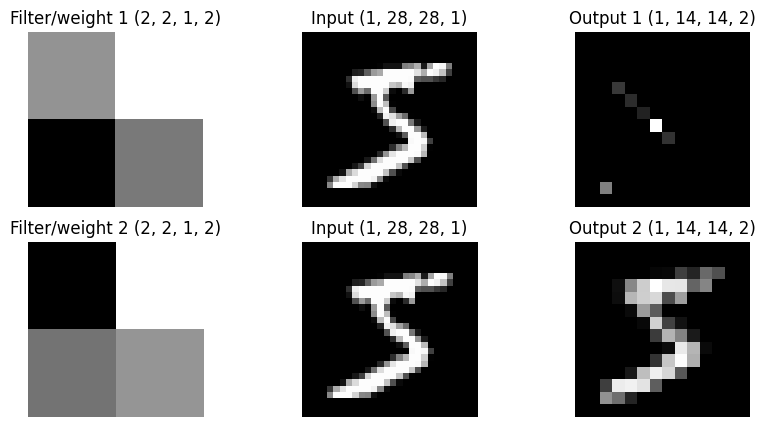

In [82]:
sample_input = np.expand_dims(X_train[0], axis=0)
sample_filters = np.random.randn(2, 2, 1, 2)
sample_biases = np.zeros((1, 1, 1, 2), dtype=np.float32)
sample_padding_shape = (0, 0,)
sample_stride_shape = (2, 2,)

sample_output = conv2d_feed_forward(sample_input, sample_filters, sample_biases, sample_padding_shape, sample_stride_shape, relu)

plt.figure(figsize=(10, 5))

# Show weight/filter 1
plt.subplot(2, 3, 1)
plt.axis('off')
plt.title(f'Filter/weight 1 {sample_filters.shape}')
plt.imshow(sample_filters[:, :, 0, 0], cmap='gray')

# Show input image
plt.subplot(2, 3, 2)
plt.axis('off')
plt.title(f'Input {sample_input.shape}')
plt.imshow(sample_input[0, :, :, 0], cmap='gray')



# Show output
plt.subplot(2, 3, 3)
plt.axis('off')
plt.title(f'Output 1 {sample_output.shape}')
plt.imshow(sample_output[0, :, :, 0], cmap='gray')

# Show weight/filter 2
plt.subplot(2, 3, 4)
plt.axis('off')
plt.title(f'Filter/weight 2 {sample_filters.shape}')
plt.imshow(sample_filters[:, :, 0, 1], cmap='gray')

# Show input image
plt.subplot(2, 3, 5)
plt.axis('off')
plt.title(f'Input {sample_input.shape}')
plt.imshow(sample_input[0, :, :, 0], cmap='gray')



# Show output
plt.subplot(2, 3, 6)
plt.axis('off')
plt.title(f'Output 2 {sample_output.shape}')
plt.imshow(sample_output[0, :, :, 1], cmap='gray')

plt.show()

## Gradient of weight of current layer - 2D Convolution

In [ ]:
def conv2d_calculate_gradient(error_current_layer, padded_input_current_layer, filters_of_current_layer, stride_shape):
    """
    Computes gradient of the weights of the current layer.
    
    @param error_current_layer [4D Numpy array]: Error generated by the current layer's output. First dimension is the batch size,
    second is height, third is width, and last layer is the number of filters used
    
    @param padded_input_current_layer [4D Numpy array]: Input vector provided to the current layer. First dimension is batch size,
    second is height (padded), third is width (padded), and the last dimension is the number of channels
    
    @param gradient_current_layer [4D Numpy array]: Current gradients of the layer
    
    @param filters_of_current_layer [4D Numpy array]: Filters of the current layer. First dimension contains height, 
    second dimension contains width, third dimension contains number of channels, and last dimension contains number of filters
    
    @param stride_shape [Tuple(Integer, Integer)]: The length of stride
    
    Returns Tuple([4D Numpy array],[4D Numpy array]]: Gradient of the weights and bias of the current layer
    """
    
    batch_size, output_height, output_width, num_filters = error_current_layer.shape
    filter_height, filter_width, filter_channels, num_filters = filters.shape
    stride_height, stride_width = stride_shape
    
    # Initialize gradients
    gradient_w = np.zeros(filters_of_current_layer.shape, dtype=np.float32)
    gradient_b = np.zeros((1, 1, 1, filters_of_current_layer[-1].shape))
    
    for batch_idx in range(batch_size):
        for height_idx in range(output_height):
            for width_idx in range(output_width):
                for filter_idx in range(num_filters):
                    # Calculate the range of the height for each convolution must be performed
                    h_start = height_idx * stride_height
                    h_end = h_start + filter_height

                    # Calculate the range of the width for each convolution must be performed
                    w_start = width_idx * stride_width
                    w_end = w_start + filter_width

                    # Get the slice of image within the range to perform convolution
                    x_slice = padded_input_current_layer[h_start:h_end, w_start:w_end, :]
                    
                    # Calculate gradient of weight for current sample, current width, current height and current filter
                    gradient_w[:, :, :, filter_idx] += x_slice * error_current_layer[batch_idx, height_idx, width_idx, filter_idx]
                    
                    # Calculate gradient of bias for current sample, current width, current height and current filter
                    gradient_b[:, :, :, filter_idx] += error_current_layer[batch_idx, height_idx, width_idx, filter_idx]
                    
    return gradient_w, gradient_b